In [21]:
from transformers import AutoModel, AutoTokenizer, AutoConfig
from datasets import load_dataset
import torch
import random
import numpy as np

seed = 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

do_random = True
model_name = "microsoft/deberta-v3-xsmall"
ds_name = "amazon_polarity"
device = "cuda:1"
dtype = torch.float16
tokenizer = AutoTokenizer.from_pretrained(model_name)
if do_random:
    config = AutoConfig.from_pretrained(model_name)
    model = AutoModel.from_config(config).to(device).to(dtype)
else:
    model = AutoModel.from_pretrained(model_name).to(device).to(dtype)
ds_dict = load_dataset(ds_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/mnt/ssd-1/alexm/miniconda3/envs/ql/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
from datasets import DatasetDict
# ds_dict = DatasetDict({"train": ds_dict["train"].select(range(16)), "test": ds_dict["test"].select(range(16))})
ds_dict = DatasetDict({"train": ds_dict["train"].select(range(3_600_000)), "test": ds_dict["test"].select(range(10_000))})
ds_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 10000
    })
})

In [23]:
import torch
from datasets import Features, Sequence, Value, ClassLabel

model.eval()
def get_last_hidden_state(exs: dict):
    encodings = tokenizer(exs["content"], truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        exs["embedding"] = outputs.last_hidden_state.squeeze(1)[:, 0, :].cpu().float()  # batch_size x embedding_size
    return exs

ds = ds_dict.with_format("torch")
feats = Features({"content": Value("string"), "label": ClassLabel(num_classes=2, names=["neg", "pos"]), "embedding": Sequence(Value("float32")), "title": Value("string")})
ds = ds.map(get_last_hidden_state, batched=True, batch_size=128, features=feats)

Map: 100%|██████████| 10000/10000 [00:15<00:00, 659.51 examples/s]


In [24]:
name = "atmallen/amazon_polarity_embeddings"
if do_random:
    name += f"_random{seed}"
ds.push_to_hub(name)

Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = ds["train"]["embedding"]
y = ds["train"]["label"]
print(y.mean(dtype=torch.float32))
clf = LogisticRegression(random_state=0).fit(X, y)
y_pred = clf.predict(ds["test"]["embedding"])
print(accuracy_score(ds["test"]["label"], y_pred))

tensor(0.5000)
0.7272


/mnt/ssd-1/alexm/miniconda3/envs/ql/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# results

In [8]:
import pickle
from mdl import MdlResult
import numpy as np

parent = "../data/sentiment-erasure/"
# erasures = ["Linear", "Q-LEACE", "None"]
# seeds = [0, 1, 2, 3, 4]
erasures = ["None", "LEACE", "Q-LEACE", "Linear"]
seeds = [0]
results = []
for erasure in erasures:
    result = dict(erasure=erasure)
    for seed in seeds:
        name = f"{erasure}_seed{seed}_on_amazon_polarity_embeddings.pkl"
        with open(parent + name, "rb") as f:
            mdl_result = pickle.load(f)

        result.update({
            f"ce_curve{seed}": mdl_result.ce_curve,
            f"sample_sizes{seed}": mdl_result.sample_sizes,
            f"mdl{seed}": mdl_result.mdl,
        })
    median_ce_curve = np.median(np.stack([result[f"ce_curve{seed}"] for seed in seeds]), axis=0)
    assert all(result[f"sample_sizes{seed}"] == result[f"sample_sizes{seed}"] for seed in seeds)
    sample_sizes = result[f"sample_sizes{seed}"]
    median_mdl = np.median(np.stack([result[f"mdl{seed}"] for seed in seeds]), axis=0)
    result.update(
        median_ce_curve=median_ce_curve,
        sample_sizes=sample_sizes,
        mdl=median_mdl,
    )
    results.append(result)

In [9]:
import pandas as pd
df = pd.DataFrame(results)

In [10]:
df

,erasure,ce_curve0,sample_sizes0,mdl0,median_ce_curve,sample_sizes,mdl
0,None,"[0.5572372298016042, 0.5184670482402801, 0.471...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",1.734498,"[0.5572372298016042, 0.5184670482402801, 0.471...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",1.734498
1,LEACE,"[0.9629797119754583, 0.8902902826988269, 0.815...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",1.592949,"[0.9629797119754583, 0.8902902826988269, 0.815...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",1.592949
2,Q-LEACE,"[1.0001316850755007, 1.0000007406898412, 1.000...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",4.151715,"[1.0001316850755007, 1.0000007406898412, 1.000...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",4.151715
3,Linear,"[1.0000017788955973, 1.0001298788163426, 1.000...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",3.593908,"[1.0000017788955973, 1.0001298788163426, 1.000...","[768, 1984, 3909, 6957, 11783, 19424, 31523, 5...",3.593908


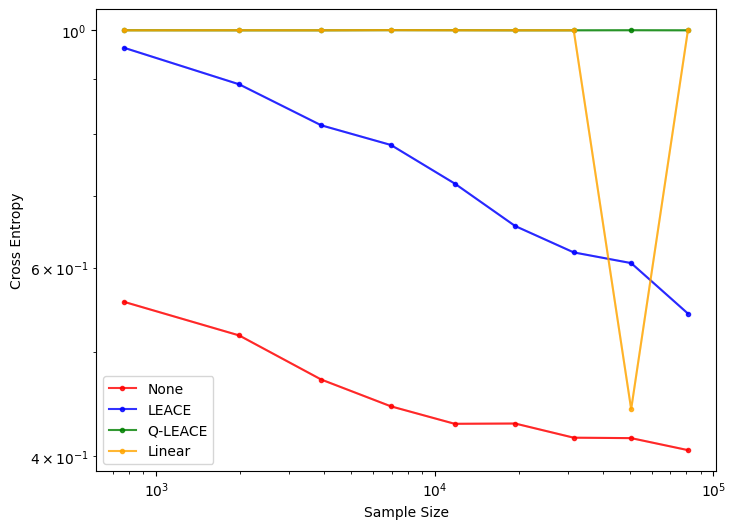

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
for erasure, color in zip(erasures, ["red", "blue", "green", "orange"]):
    sub_df = df[df.erasure == erasure]
    x = sub_df.sample_sizes.iloc[0][:-1]
    y = sub_df.median_ce_curve.iloc[0]
    ax.plot(x, y, label=erasure, alpha=0.8, marker=".", color=color)
    for seed in seeds:
        x = sub_df.sample_sizes.iloc[0][:-1]
        y = sub_df[f"ce_curve{seed}"].iloc[0]
        ax.plot(x, y, alpha=0.2, color=color)
ax.set_xlabel("Sample Size")
ax.set_ylabel("Cross Entropy")
# ax.set_ylim(0, 1.1)
ax.loglog()
ax.legend()